<a href="https://colab.research.google.com/github/hannahweber244/AAML_Code/blob/main/AAML_Wettervorhersage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import json
import argparse
from copy import deepcopy
import pandas as pd
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import operator

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Daten herunterladen

In [ ]:
!gdown --id 1KJc4JQPshwXtNdPIJypTjnKo3ViJ3QAZ
!unzip weather-hourly.zip

Downloading...
From: https://drive.google.com/uc?id=1KJc4JQPshwXtNdPIJypTjnKo3ViJ3QAZ
To: /content/weather-hourly.zip
12.6MB [00:00, 58.7MB/s]
Archive:  weather-hourly.zip
  inflating: city_attributes.csv     
  inflating: humidity.csv            
  inflating: pressure.csv            
  inflating: temperature.csv         
  inflating: weather_description.csv  
  inflating: wind_direction.csv      
  inflating: wind_speed.csv          


## Datenvorverarbeitung

In [ ]:
df = pd.read_csv('temperature.csv')
data = df[['datetime','Portland']].dropna(how = 'any')
print(data.shape)
data.head()

(45252, 2)


,datetime,Portland
1,2012-10-01 13:00:00,282.080000
2,2012-10-01 14:00:00,282.083252
3,2012-10-01 15:00:00,282.091866
4,2012-10-01 16:00:00,282.100481
5,2012-10-01 17:00:00,282.109095


In [ ]:
data.dtypes

datetime     object
Portland    float64
dtype: object

In [ ]:
data.datetime = pd.to_datetime(data.datetime)
data.dtypes

datetime    datetime64[ns]
Portland           float64
dtype: object

In [ ]:
end_training = pd.to_datetime('2016-11-30 00:00:00')
data_train = data.where(data.datetime < end_training).dropna(how = 'all').reset_index(drop=True)
data_test = data.where(data.datetime >= end_training).dropna(how = 'all').reset_index(drop = True)
data_test.head()

,datetime,Portland
0,2016-11-30 00:00:00,284.15
1,2016-11-30 01:00:00,283.29
2,2016-11-30 02:00:00,281.44
3,2016-11-30 03:00:00,280.87
4,2016-11-30 04:00:00,280.27


In [ ]:
data_train.tail()

,datetime,Portland
36486,2016-11-29 19:00:00,281.57
36487,2016-11-29 20:00:00,282.43
36488,2016-11-29 21:00:00,282.41
36489,2016-11-29 22:00:00,283.12
36490,2016-11-29 23:00:00,283.97


In [ ]:
sequence_length = 36
def create_dataset(series, window_size = 5):
    result = list()
    for i in range(len(series)-window_size-1):
        obs = np.array(series[i:i+window_size])
        lab = np.array(series[i+window_size+1])
        result.append((obs,lab))
    return result

train_ = create_dataset(data_train['Portland'], window_size = sequence_length)
test_ = create_dataset(data_test['Portland'], window_size = sequence_length)

In [ ]:
train_[:1]

[(array([282.08      , 282.08325197, 282.09186648, 282.10048098,
         282.10909548, 282.11770998, 282.12632448, 282.13493898,
         282.14355348, 282.15216798, 282.16078248, 282.16939698,
         282.17801149, 282.18662599, 282.19524049, 282.20385499,
         282.21246949, 282.22108399, 282.22969849, 282.23831299,
         282.2469275 , 282.255542  , 282.2641565 , 282.272771  ,
         282.2813855 , 282.29      , 282.51      , 284.44      ,
         287.86      , 292.26      , 292.73      , 295.57      ,
         297.94      , 300.        , 300.55      , 300.37      ]),
  array(296.42))]

## Modell

In [ ]:
class Predictor(nn.Module):

    def __init__(self, input_dim = 1, hidden_dim = 1, predict_size = 1, num_layers = 1, seq_len = 5):
        super(Predictor, self).__init__()
        self.hidden_dim = predict_size
        self.batch_size = 0
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.rnn = nn.ModuleList()
        #for k in range(seq_len):
        #    self.rnn.append(nn.LSTMCell(input_size=input_dim, hidden_size=hidden_dim))

        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(hidden_dim, predict_size),
                                nn.ReLU())
        self.LSTM = nn.LSTM(input_size=input_dim, 
                            hidden_size = predict_size, 
                            num_layers = num_layers, 
                            batch_first = True)
    
    def set_batch_size(self, batch_size):
        self.batch_size = batch_size
    
    def forward(self,x):
        assert self.batch_size > 0, 'set a batch size'

        #reshape x for LSTM
        x = x.reshape((self.batch_size, self.seq_len, self.input_dim)).double()

        #reshape x for LSTMCell
        #x = x.reshape((self.batch_size, self.input_dim)).double()
        
        
        #initialize hidden and cell state for LSTMCell
        #hidden_, cell_ = torch.zeros(self.batch_size, self.hidden_dim).double().to(device), torch.zeros(self.batch_size, self.hidden_dim).double().to(device)
        #initialize hidden and cell state for LSTM class 
        hidden_, cell_ = torch.zeros((1*self.num_layers, self.batch_size, self.hidden_dim)).double().to(device), torch.zeros((1*self.num_layers, self.batch_size, self.hidden_dim)).double().to(device)

        #eingabe von x ins LSTM Layer
        x, (hidden_, cell_) = self.LSTM(x, (hidden_, cell_))

        #eingabe von x in die LSTMCell Layer
        #for i,lstm in enumerate(self.rnn):
        #    x_ = x[:,i]
        #    x_ = x_.reshape((self.batch_size, self.input_dim)).double().to(device)
        #    hidden_, cell_ = lstm(x_, (hidden_, cell_))
        
        #übergabe in fc wenn lstm genutzt wird
        if len(hidden_.shape) == 3:
            x = self.fc(hidden_[-1])
        else:
            x = self.fc(hidden_)
        return x

In [ ]:
def create_batches(data_list, batch_size = 64):
    batches = list()
    batch = list()

    labels = list()
    label = list()
    for i, (d,l) in enumerate(data_list, start = 1):
        
        if i % batch_size == 0:
            batch.append(torch.from_numpy(d))
            label.append(torch.from_numpy(l))

            batch = torch.stack(batch).to(device)
            label = torch.stack(label).to(device)

            batches.append(batch)
            labels.append(label)

            label = list()
            batch = list()
        else:
            batch.append(torch.from_numpy(d))
            label.append(torch.from_numpy(l))

    if len(batch) > 0:
        batch.append(torch.from_numpy(d))
        label.append(torch.from_numpy(l))

        batch = torch.stack(batch)
        label = torch.stack(label)

        batches.append(batch)
        labels.append(label)
    return batches, labels

In [ ]:
train_tens, train_labs = create_batches(train_)
test_tens, test_labs = create_batches(test_, batch_size=1)

In [ ]:
train_tens[0].shape

torch.Size([64, 36])

In [ ]:
train_labs[0].shape

torch.Size([64])

In [ ]:
def train():
    avg_loss = 0
    model.train()
    for i, data in enumerate(train_tens):
        batch_size = data.shape[0]
        label = train_labs[i]
        label,data = label.to(device), data.to(device)
        model.set_batch_size(batch_size)

        optimizer.zero_grad()#reset gradients 

        prediction = model(data.double())

        label = label.double()
        prediction = prediction.double()

        #square root mse als loss
        loss = torch.sqrt(criterion(prediction, label))
        #loss = criterion(prediction, label)
        avg_loss += loss.data

        loss.backward()
        optimizer.step()
    return avg_loss/len(train_tens)

def test():
    model.eval()
    error = 0
    prediction_list = list()
    with torch.no_grad():
        for i, data in enumerate(test_tens):
            data = data.double().to(device)
            label = test_labs[i].double().to(device)
            batch_size = data.shape[0]
            model.set_batch_size(batch_size)
            prediction = model(data)
            loss = torch.sqrt(criterion(prediction, label))
            error += loss.data
            prediction_list.append((prediction.cpu().numpy(), label.cpu().numpy()))
    return error/len(test_tens), prediction_list
    #pass

In [ ]:
#model = Predictor(seq_len=5).double().to(device)
#for param in model.parameters():
#    param.requires_grad = False
#    print(param.shape)
#    for p in range(param.shape[0]):
#
#        param[p] = torch.zeros(len(param[0]))
#    break
#for name, parameter in model.named_parameters():
#    print(name, parameter)
#    break

In [ ]:
#model = Predictor(seq_len=sequence_length, num_layers=1).double().to(device)
print(model)
lr = 0.001
#optimierer und lossfunktion definieren
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss().to(device)

loss_df = pd.DataFrame(columns = ['epoche', 'loss', 'error'])

for e in range(1,200):
    #print('epoche', e)
    l = train()
    if (e+1)%10 == 0:
        error, p_ = test()
        print(f"=========== Epoche {e+1} ===========")
        print('Testerror:', error.cpu().numpy())
        loss_df.loc[len(loss_df), :] = [e, l, error]

Predictor(
  (rnn): ModuleList()
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1, out_features=1, bias=True)
    (5): ReLU()
  )
  (LSTM): LSTM(1, 1, batch_first=True)
)
=========== Epoche 10 ===========
Testerror: 165.49605238360476
=========== Epoche 20 ===========
Testerror: 159.79606966307878
=========== Epoche 30 ===========
Testerror: 154.09608893346592
=========== Epoche 40 ===========
Testerror: 148.3961104072533
=========== Epoche 50 ===========
Testerror: 142.69613443448375
=========== Epoche 60 ===========
Testerror: 136.99616143860754
=========== Epoche 70 ===========
Testerror: 131.29619193481938
=========== Epoche 80 ===========
Testerror: 125.59622655506195
=========== Epoche 90 ===========
Testerror: 119.89626608137733
=========== Epoche 100 ===========
Testerror: 114.19631149090641
=========== Epoche 110 ===========
Teste

Text(0.5, 1.0, 'Error auf Testdaten')

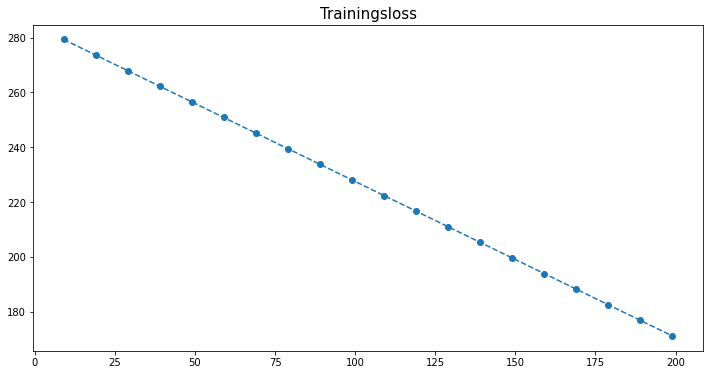

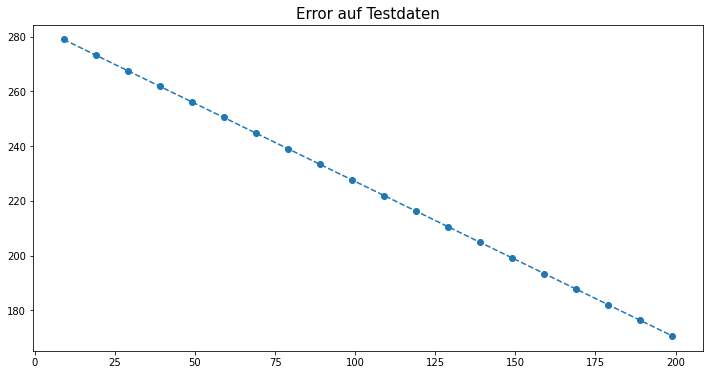

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(loss_df.epoche, loss_df.loss, 'o', c = 'tab:blue')
plt.plot(loss_df.epoche, loss_df.loss, '--', c = 'tab:blue')
plt.title('Trainingsloss', fontsize = 15)

plt.figure(figsize = (12,6))
plt.plot(loss_df.epoche, loss_df.error, 'o', c = 'tab:blue')
plt.plot(loss_df.epoche, loss_df.error, '--', c = 'tab:blue')
plt.title('Error auf Testdaten', fontsize = 15)

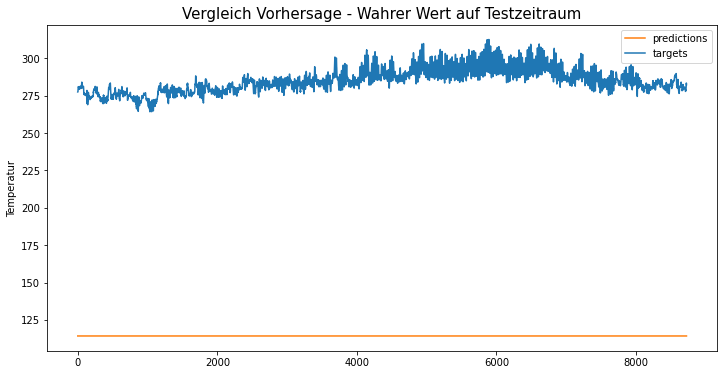

In [ ]:
target = [d[0] for _, d in p_]
predictions = [t[0][0] for t, _ in p_]
plt.figure(figsize=(12,6))
plt.plot(predictions, c = 'tab:orange', label = 'predictions')
plt.plot(target, c = 'tab:blue', label = 'targets')
plt.ylabel('Temperatur')
plt.title('Vergleich Vorhersage - Wahrer Wert auf Testzeitraum', fontsize = 15)
plt.legend();